## 1) Packages and Data

Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime
import math
from numpy.random import choice
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import namedtuple, deque

import yfinance as yf

Get Market Data

In [3]:
ticker_symbol = "^GSPC" # ticker for s&p500

sp500 = yf.Ticker(ticker_symbol) # data for s&p500

hist = sp500.history(period="10y")

print(hist)

                                  Open         High          Low        Close  \
Date                                                                            
2014-06-02 00:00:00-04:00  1923.869995  1925.880005  1915.979980  1924.969971   
2014-06-03 00:00:00-04:00  1923.069946  1925.069946  1918.790039  1924.239990   
2014-06-04 00:00:00-04:00  1923.060059  1928.630005  1918.599976  1927.880005   
2014-06-05 00:00:00-04:00  1928.520020  1941.739990  1922.930054  1940.459961   
2014-06-06 00:00:00-04:00  1942.410034  1949.439941  1942.410034  1949.439941   
...                                ...          ...          ...          ...   
2024-05-23 00:00:00-04:00  5340.259766  5341.879883  5256.930176  5267.839844   
2024-05-24 00:00:00-04:00  5281.450195  5311.649902  5278.390137  5304.720215   
2024-05-28 00:00:00-04:00  5315.910156  5315.910156  5280.890137  5306.040039   
2024-05-29 00:00:00-04:00  5278.729980  5282.270020  5262.700195  5266.950195   
2024-05-30 00:00:00-04:00  5

Convert Data to CSV

In [4]:
# hist.to_csv("sp500_historical.csv")

Put CSV Data into Pandas Dataframe

In [5]:
csv = 'sp500_historical.csv'
df = pd.read_csv(csv,index_col=0) # use col 0 as row labels
type(df)

pandas.core.frame.DataFrame

## 2) Explore Data

In [6]:
df.shape

(2517, 7)

In [7]:
df.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-05-19 00:00:00-04:00,1876.660034,1886.000000,1872.420044,1885.079956,2664250000,0.0,0.0
2014-05-20 00:00:00-04:00,1884.880005,1884.880005,1868.140015,1872.829956,3007700000,0.0,0.0
2014-05-21 00:00:00-04:00,1873.339966,1888.800049,1873.339966,1888.030029,2777140000,0.0,0.0
2014-05-22 00:00:00-04:00,1888.189941,1896.329956,1885.390015,1892.489990,2759800000,0.0,0.0
2014-05-23 00:00:00-04:00,1893.319946,1901.260010,1893.319946,1900.530029,2396280000,0.0,0.0


Get statistics of data

In [8]:
df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,2517.000000,2517.000000,2517.000000,2517.000000,2.517000e+03,2517.0,2517.0
mean,3125.554992,3142.307463,3107.622268,3126.118749,3.969351e+09,0.0,0.0
std,951.181563,956.973539,945.492442,951.530421,9.650665e+08,0.0,0.0
min,1833.400024,1847.000000,1810.099976,1829.079956,1.296530e+09,0.0,0.0
25%,2185.169922,2188.060059,2179.419922,2186.479980,3.376750e+09,0.0,0.0
50%,2866.699951,2885.250000,2854.229980,2871.679932,3.793950e+09,0.0,0.0
75%,4013.020020,4046.459961,3980.310059,4016.219971,4.326660e+09,0.0,0.0
max,5310.069824,5325.490234,5296.189941,5308.149902,9.976520e+09,0.0,0.0


Plot stock movement

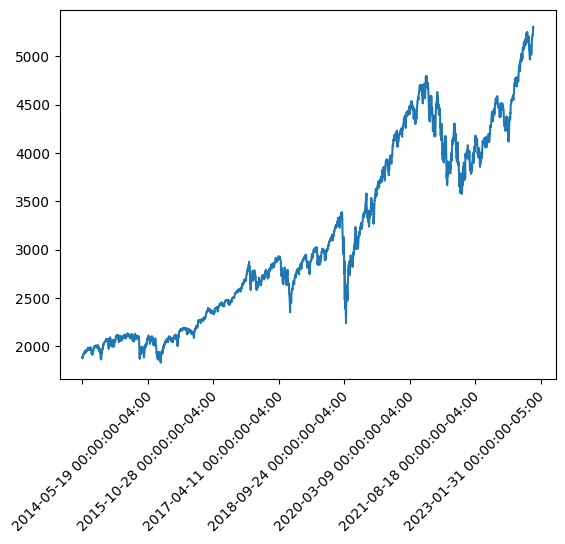

In [9]:
import matplotlib.dates as mdates
plt.plot(df.index, df['Close'])
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=1))
plt.show()

Data Cleaning

In [10]:
print('Null Values =', df.isnull().values.any()) # check for null values

Null Values = False


In [11]:
df = df.fillna(method='bfill') # if there are null values, replace them with the next value in the dataset

/var/folders/pd/9gc451qn4pq79vrqt_r9xlfr0000gn/T/ipykernel_63412/3377758463.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill') # if there are null values, replace them with the next value in the dataset


In [12]:
df.head(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-05-19 00:00:00-04:00,1876.660034,1886.000000,1872.420044,1885.079956,2664250000,0.0,0.0
2014-05-20 00:00:00-04:00,1884.880005,1884.880005,1868.140015,1872.829956,3007700000,0.0,0.0


Remove Last Two Colums

In [13]:
cols = df.columns.to_list() # converts columns of df into a list
drop = cols[-2:] # get last two columns of df
df = df.drop(columns=drop) # delete those columns

df.head(2)

,Open,High,Low,Close,Volume
Date,,,,,
2014-05-19 00:00:00-04:00,1876.660034,1886.000000,1872.420044,1885.079956,2664250000
2014-05-20 00:00:00-04:00,1884.880005,1884.880005,1868.140015,1872.829956,3007700000


## 3) Build Datasets

Split Dataset

In [14]:
X = list(df['Close']) # create a list of closing prices from df
X = [float(x) for x in X] # convert each element to a float

In [15]:
print(X[0:10])

[1885.0799560546875, 1872.8299560546875, 1888.030029296875, 1892.489990234375, 1900.530029296875, 1911.9100341796875, 1909.780029296875, 1920.030029296875, 1923.5699462890625, 1924.969970703125]


In [16]:
from sklearn.model_selection import train_test_split
test_size = 0.2
X_train, x_test = train_test_split(X, test_size=test_size, shuffle=False) # use test size 20%

In [17]:
print(X_train[0:10])

[1885.0799560546875, 1872.8299560546875, 1888.030029296875, 1892.489990234375, 1900.530029296875, 1911.9100341796875, 1909.780029296875, 1920.030029296875, 1923.5699462890625, 1924.969970703125]


# 4) Build Model

Memory Class: Cyclic Buffer of bounded size that holds the transitions observed recently. It also implements a sample() method for selecting a random batch of transitions for training

In [29]:
class Memory():
    def __init__(self, capacity=10000):
        self.memory = deque([], maxlen=capacity)
    def push(self, state, action, next_state, reward, push):
        self.memory.append((state, action, next_state, reward, push))
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

Neural Network Class: Create the Q-Network used in the DQN algorithm to approximate the Q-Value function

In [30]:
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 8)
        self.output = nn.Linear(8, action_size)

        self.lr = 0.001
        self.loss_fn = nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=self.lr)

        #self.device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
        self.device = 'cpu'
        self.to(self.device)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.output(x)
        return x
    
    def _train(self, X, y):
        self.train()
        self.optimizer.zero_grad()
        y_pred = self.forward(X)
        loss = self.loss_fn(y_pred, y)
        loss.backward()
        self.optimizer.step()
        return loss.item()
        

Agent Class: Define an Agent that is designed to act as a reinforcement learning agent for stock trading using a neural network. The agent can buy, sell or hold a stock. It learns from its experiences over time

In [31]:
class Agent():
    def __init__(self, state_size, is_eval=False, model_name=""):
        super(Agent, self).__init__()
        self.state_size = state_size 
        self.action_size = 3
        self.memory = Memory(1000)
        self.inventory = []
        self.is_eval = is_eval
        self.model_name = model_name
        self.gamma = 0.95
        self.epsilon = 1.0
        self.eps_min = 0.01
        self.eps_dec = 0.9

        self.model = DQN(self.state_size, self.action_size)
        if is_eval:
            print("load model "+ model_name)
            self.model = torch.load(model_name)
            self.model.eval()

    # CHOOSE ACTION 
    def act(self, state):
        if not self.is_eval and random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.tensor(state, dtype=torch.float).to(self.model.device)
        actions = self.model.forward(state).detach().numpy()
        return np.argmax(actions[0])

    # EXPERIENCE REPLAY
    def expReplay(self, batch_size):
        minibatch = self.memory.sample(batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = torch.tensor(state, dtype=torch.float).to(self.model.device) 
            next_state = torch.tensor(next_state, dtype=torch.float).to(self.model.device) 
            target = reward
            if not done:
                target = reward + self.gamma * torch.max(self.model.forward(next_state)[0])

            target_f = self.model.forward(state)
            target_f[0][action] = target

            self.model._train(state, target_f)
        if self.epsilon > self.eps_min:
            self.epsilon *= self.eps_dec

Helper Functions

In [32]:
def formatPrice(n):
    return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))

def sigmoid(x):
    if x >= 0:
        return 1 / (1 + math.exp(-x))
    else:
        return 1 / (1 + math.exp(x))

def getState(data, t, n):
    d = t - n + 1 
    block = data[d:t+1] if d >= 0 else -d * [data[0]] + data[0:t + 1]
    res = [] 
    for i in range(n-1): 
        res.append(sigmoid(block[i+1]-block[i])) 
    return np.array([res]) 

def plot_behavior(data_input, states_buy, states_sell, profit):
    plt.figure(figsize=(15,5))
    plt.plot(data_input, color='g', lw=2.) 
    plt.plot(data_input, '^', markersize=10, color='b', label='Buying Signal', markevery=states_buy)
    plt.plot(data_input, 'v', markersize=10, color='r', label='Selling Signal', markevery=states_sell)
    plt.title('Total Gains: %f'%(profit)) 
    plt.legend() 
    plt.show() 

# 5) Train Model

Train the Agent

Epoch 0/10
--------------------------------
Total Profit: $870.65
--------------------------------


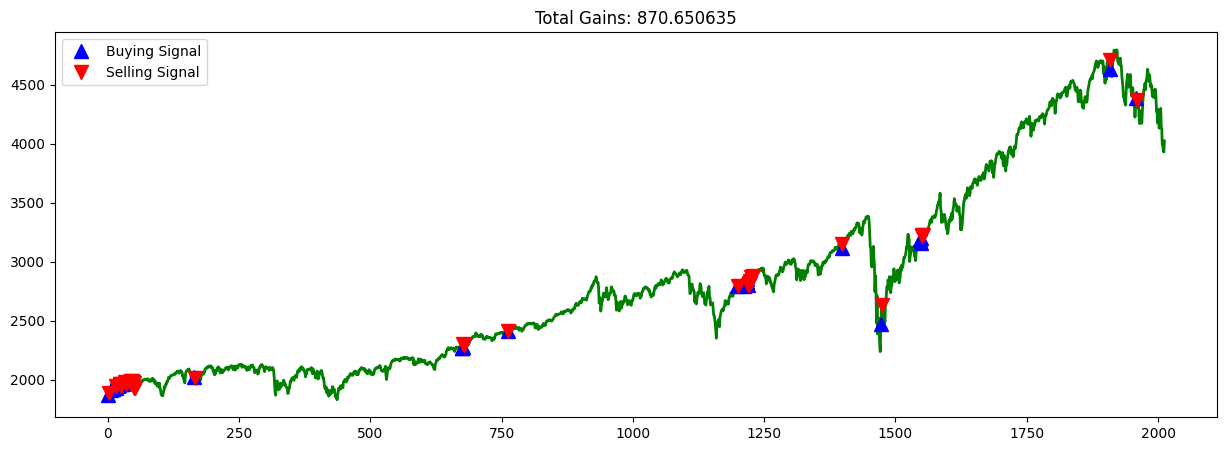

Epoch 1/10
--------------------------------
Total Profit: $592.29
--------------------------------


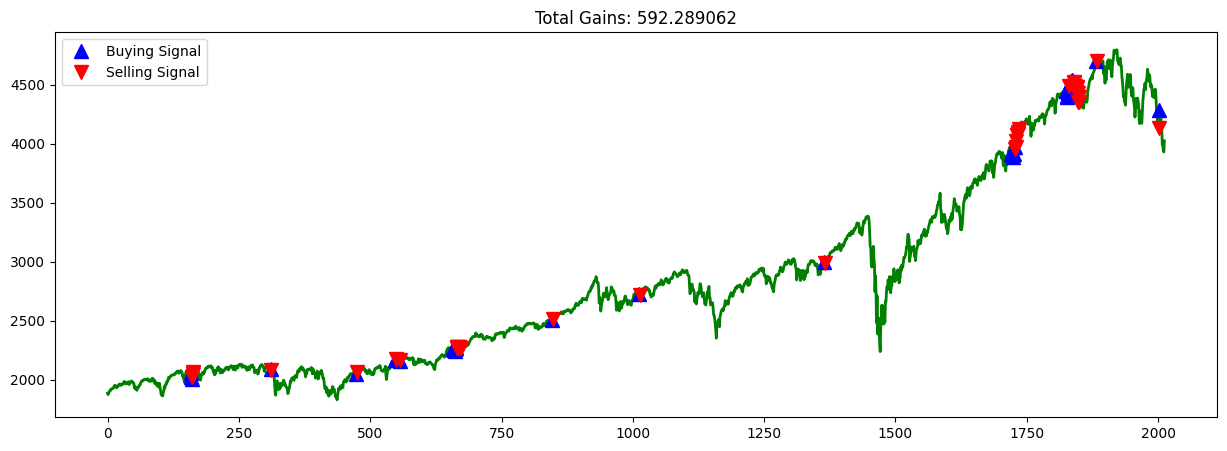

Epoch 2/10
--------------------------------
Total Profit: $1685.74
--------------------------------


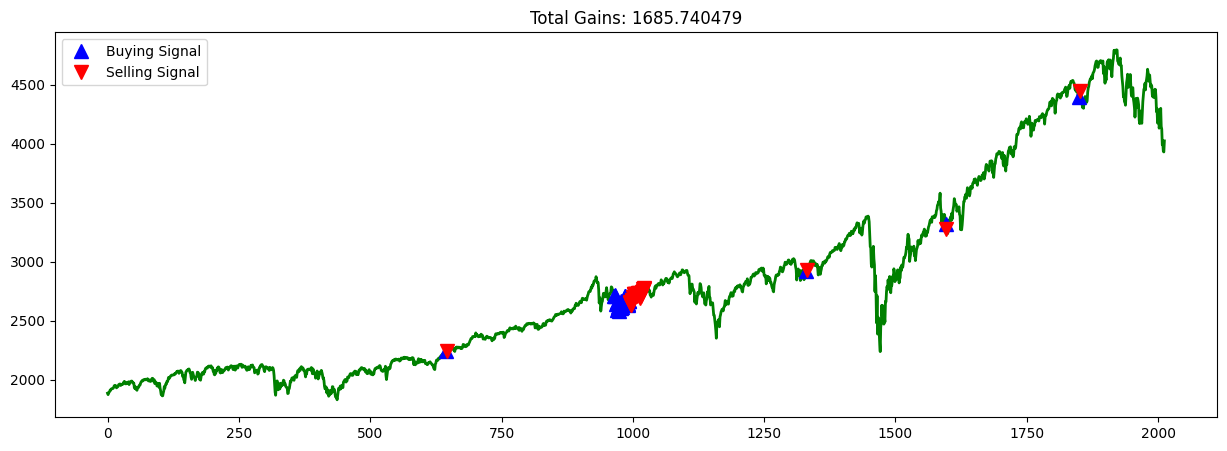

Epoch 3/10
--------------------------------
Total Profit: -$3119.02
--------------------------------


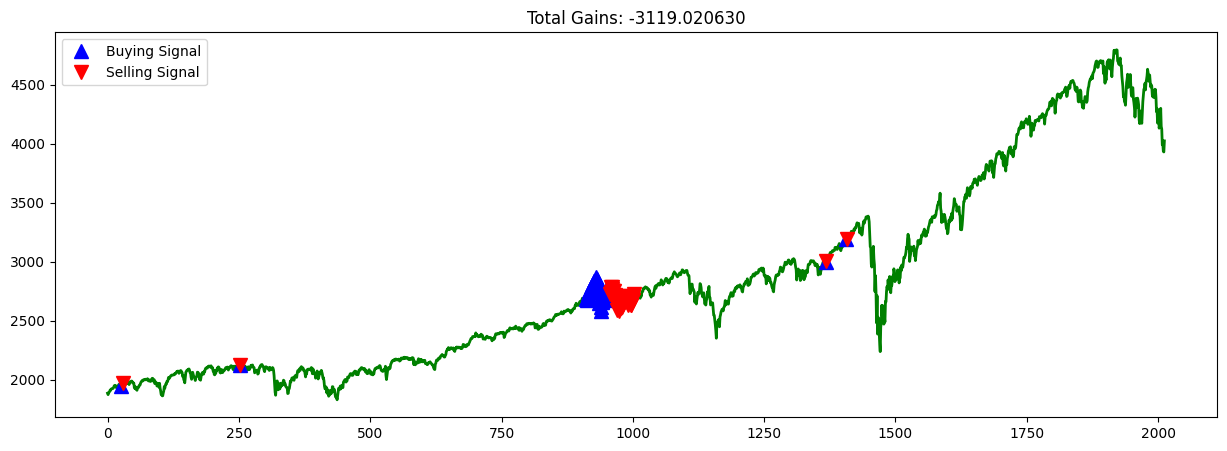

Epoch 4/10
--------------------------------
Total Profit: $36238.81
--------------------------------


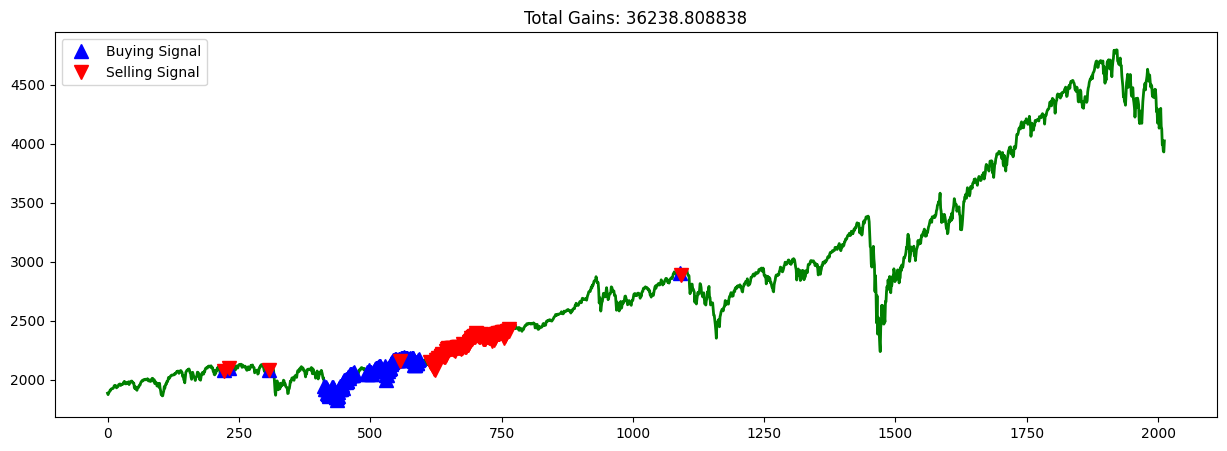

Epoch 5/10
--------------------------------
Total Profit: $1038913.67
--------------------------------


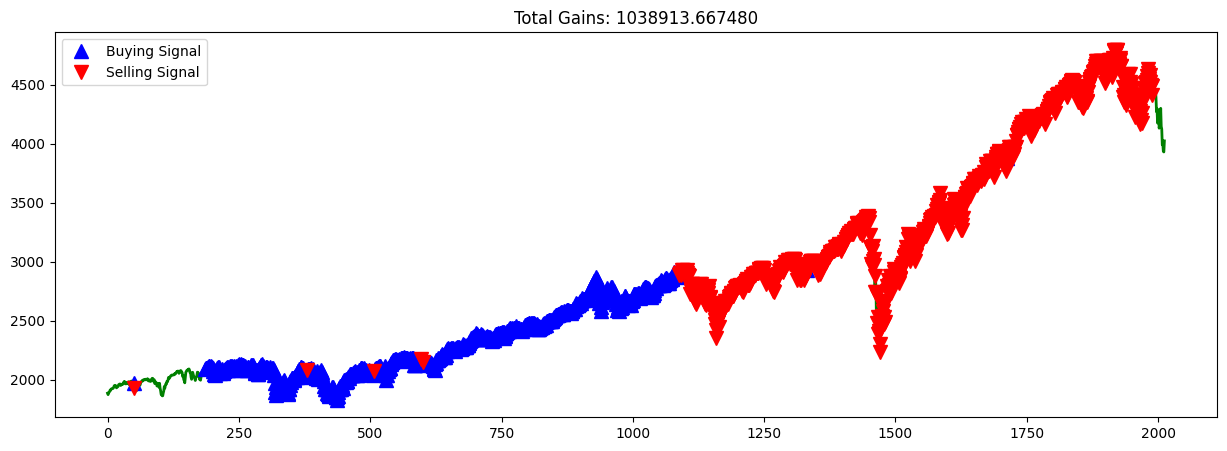

Epoch 6/10
--------------------------------
Total Profit: $67.66
--------------------------------


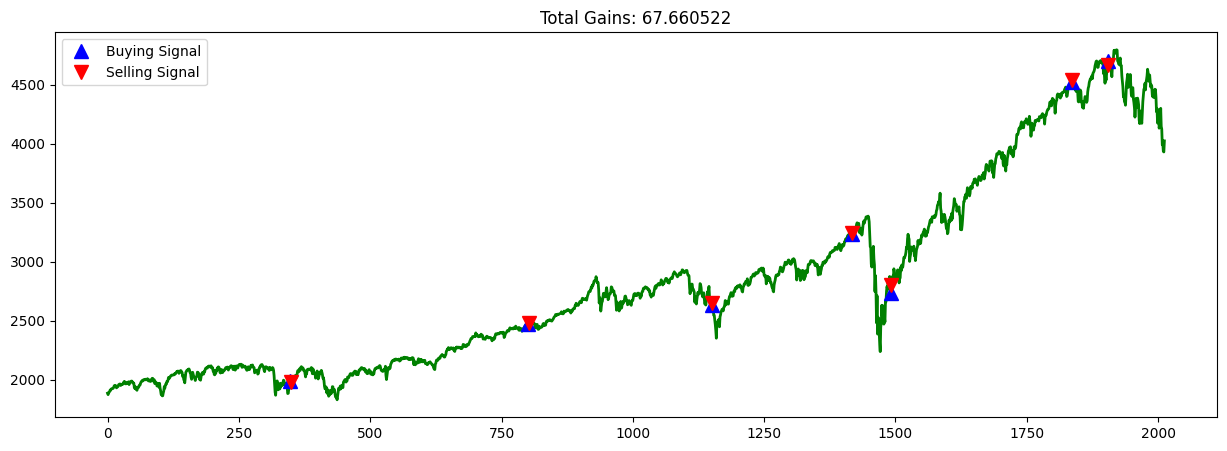

Epoch 7/10
--------------------------------
Total Profit: $48.19
--------------------------------


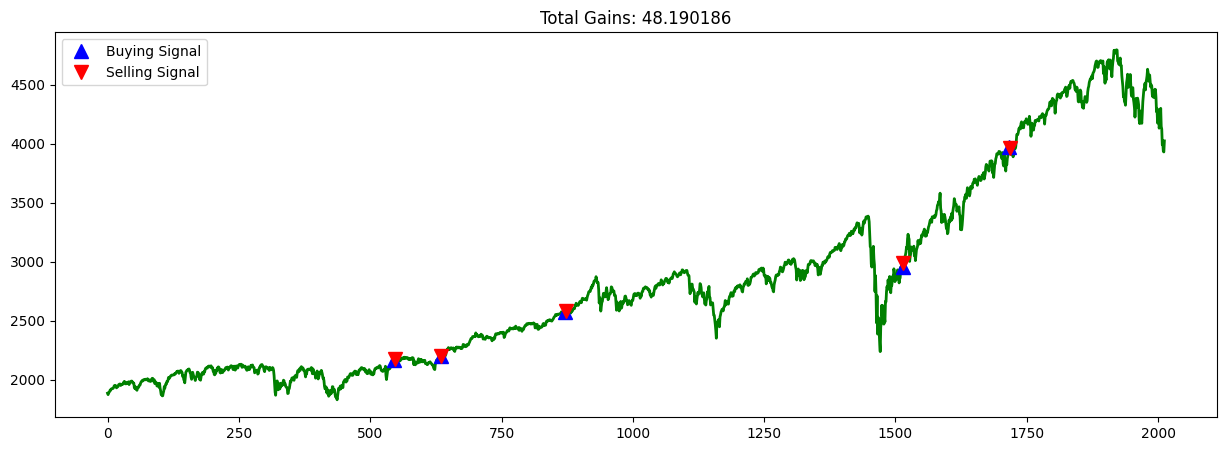

Epoch 8/10
--------------------------------
Total Profit: $85042.15
--------------------------------


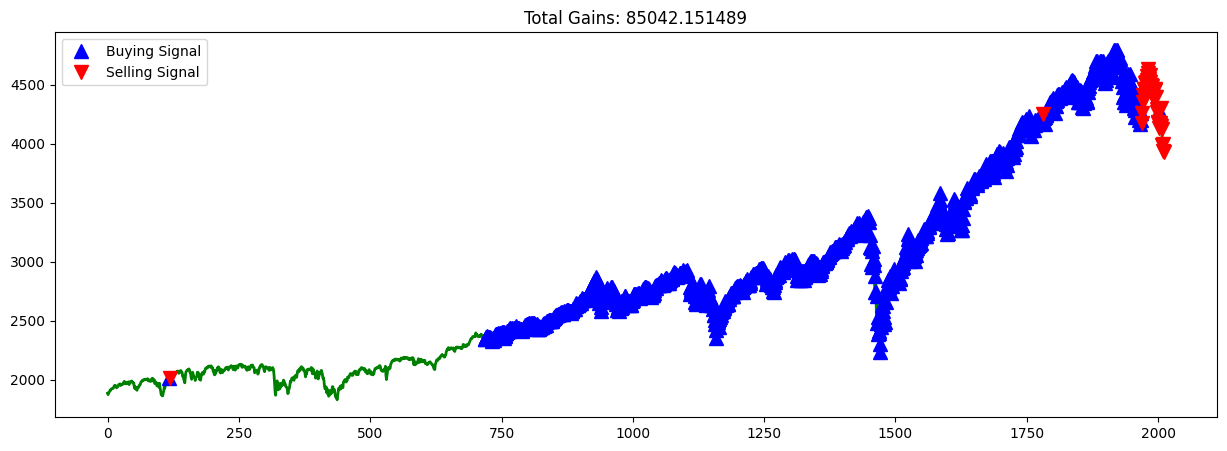

Epoch 9/10
--------------------------------
Total Profit: -$59.88
--------------------------------


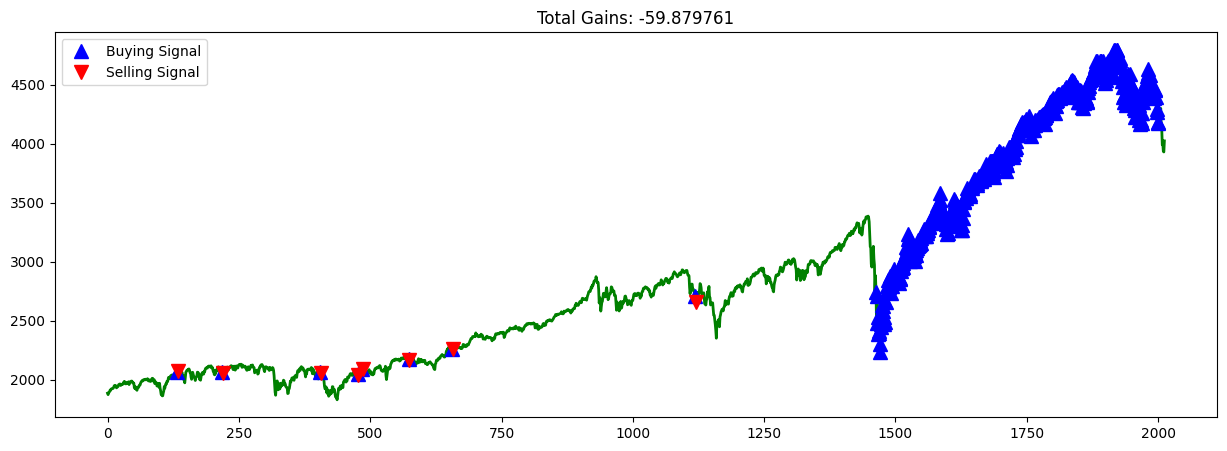

Epoch 10/10
--------------------------------
Total Profit: $169.75
--------------------------------


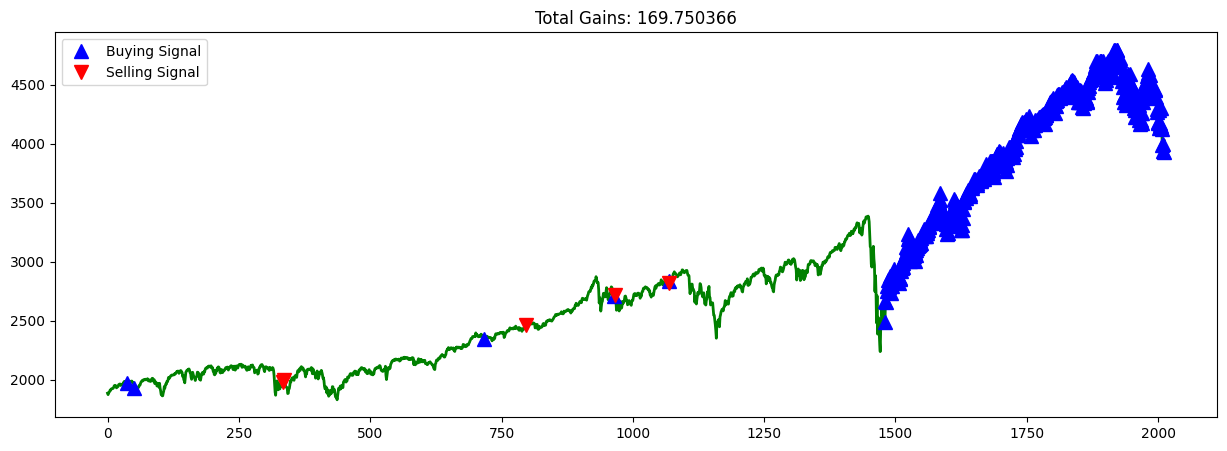

In [33]:
window_size = 1
agent = Agent(window_size)
data = X_train
l = len(data)-1
batch_size = 32
epochs = 10
for e in range(epochs+1): 
    print("Epoch " + str(e) + "/" + str(epochs)) 
    state = getState(data, 0, window_size + 1) 
    total_profit = 0 
    agent.inventory = [] 
    states_buy = []
    states_sell = [] 
    for t in range(l): 
        action = agent.act(state)     
        next_state = getState(data, t+1, window_size+1) 
        reward = 0
        if action == 1: 
            agent.inventory.append(data[t]) 
            states_buy.append(t) 
        elif action == 2 and len(agent.inventory) > 0: 
            bought_price = agent.inventory.pop(0) 
            reward = max(data[t] - bought_price, 0) 
            total_profit += (data[t] - bought_price) 
            states_sell.append(t)  
        done = True if t == l - 1 else False 
        agent.memory.push(state, action, reward, next_state, done) 
        state = next_state 
        if done: 
            print("--------------------------------")
            print("Total Profit: " + formatPrice(total_profit))
            print("--------------------------------")
            plot_behavior(data, states_buy, states_sell, total_profit) 
        if agent.memory.__len__() > batch_size:
            agent.expReplay(batch_size)

path = "model_ep"+str(e)+".pth"
torch.save(agent.model, path)


## Results

In [34]:
from torchsummary import summary
summary(agent.model, input_size=(agent.state_size,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]             128
            Linear-2                   [-1, 32]           2,080
            Linear-3                    [-1, 8]             264
            Linear-4                    [-1, 3]              27
Total params: 2,499
Trainable params: 2,499
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [36]:
print("Model's state_dict:")
for param_tensor in agent.model.state_dict():
    print(param_tensor, '\t', agent.model.state_dict()[param_tensor].size())
print("Optimizer's state_dict:")
for var_name in agent.model.optimizer.state_dict():
    print(var_name, '\t', agent.model.optimizer.state_dict()[var_name])

Model's state_dict:
fc1.weight 	 torch.Size([64, 1])
fc1.bias 	 torch.Size([64])
fc2.weight 	 torch.Size([32, 64])
fc2.bias 	 torch.Size([32])
fc3.weight 	 torch.Size([8, 32])
fc3.bias 	 torch.Size([8])
output.weight 	 torch.Size([3, 8])
output.bias 	 torch.Size([3])
Optimizer's state_dict:
state 	 {0: {'step': tensor(707200.), 'exp_avg': tensor([[ 5.6052e-45],
        [ 0.0000e+00],
        [-5.6052e-45],
        [ 0.0000e+00],
        [ 5.6052e-45],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 5.6052e-45],
        [ 5.6052e-45],
        [ 5.6052e-45],
        [-5.6052e-45],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 5.6052e-45],
        [ 5.6052e-45],
        [ 5.6052e-45],
        [-5.6052e-45],
        [ 0.0000e+00],
        [-5.6052e-45],
        [ 0.0000e+00],
        [-5.6052e-45],
        [ 0.0000e+00],
        [ 5.6052e-45],
        [ 0.000

In [37]:
test_data = x_test
l_test = len(test_data) - 1
window_size = 1
is_eval = True

eval_agent = Agent(window_size, is_eval, "model_ep10.pth")

state = getState(test_data, 0, window_size + 1)
total_profit = 0
states_buy_test = []
states_sell_test = []

load model model_ep10.pth


In [38]:
print("Model's state_dict:")
for param_tensor in eval_agent.model.state_dict():
    print(param_tensor, '\t', eval_agent.model.state_dict()[param_tensor].size())
print("Optimizer's state_dict:")
for var_name in eval_agent.model.optimizer.state_dict():
    print(var_name, '\t', eval_agent.model.optimizer.state_dict()[var_name])

Model's state_dict:
fc1.weight 	 torch.Size([64, 1])
fc1.bias 	 torch.Size([64])
fc2.weight 	 torch.Size([32, 64])
fc2.bias 	 torch.Size([32])
fc3.weight 	 torch.Size([8, 32])
fc3.bias 	 torch.Size([8])
output.weight 	 torch.Size([3, 8])
output.bias 	 torch.Size([3])
Optimizer's state_dict:
state 	 {0: {'step': tensor(707200.), 'exp_avg': tensor([[ 5.6052e-45],
        [ 0.0000e+00],
        [-5.6052e-45],
        [ 0.0000e+00],
        [ 5.6052e-45],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 5.6052e-45],
        [ 5.6052e-45],
        [ 5.6052e-45],
        [-5.6052e-45],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 5.6052e-45],
        [ 5.6052e-45],
        [ 5.6052e-45],
        [-5.6052e-45],
        [ 0.0000e+00],
        [-5.6052e-45],
        [ 0.0000e+00],
        [-5.6052e-45],
        [ 0.0000e+00],
        [ 5.6052e-45],
        [ 0.000

Buy:  $4008.01
Buy:  $4088.85
Buy:  $3923.68
Buy:  $3900.79
Buy:  $3901.36
Buy:  $3973.75
Buy:  $3941.48
Buy:  $3978.73
Buy:  $4057.84
Buy:  $4158.24
Buy:  $4132.15
Buy:  $4101.23
Buy:  $4176.82
Buy:  $4108.54
Buy:  $4121.43
Buy:  $4160.68
Buy:  $4115.77
Buy:  $4017.82
Buy:  $3900.86
Buy:  $3749.63
Buy:  $3735.48
Buy:  $3789.99
Buy:  $3666.77
Buy:  $3674.84
Buy:  $3764.79
Buy:  $3759.89
Buy:  $3795.73
Buy:  $3911.74
Buy:  $3900.11
Buy:  $3821.55
Buy:  $3818.83
Buy:  $3785.38
Buy:  $3825.33
Buy:  $3831.39
Buy:  $3845.08
Buy:  $3902.62
Buy:  $3899.38
Buy:  $3854.43
Buy:  $3818.80
Buy:  $3801.78
Buy:  $3790.38
Buy:  $3863.16
Buy:  $3830.85
Buy:  $3936.69
Buy:  $3959.90
Buy:  $3998.95
Buy:  $3961.63
Buy:  $3966.84
Buy:  $3921.05
Buy:  $4023.61
Buy:  $4072.43
Buy:  $4130.29
Buy:  $4118.63
Buy:  $4091.19
Buy:  $4155.17
Buy:  $4151.94
Buy:  $4145.19
Buy:  $4140.06
Buy:  $4122.47
Buy:  $4210.24
Buy:  $4207.27
Buy:  $4280.15
Buy:  $4297.14
Buy:  $4305.20
Buy:  $4274.04
Buy:  $4283.74
Buy:  $422

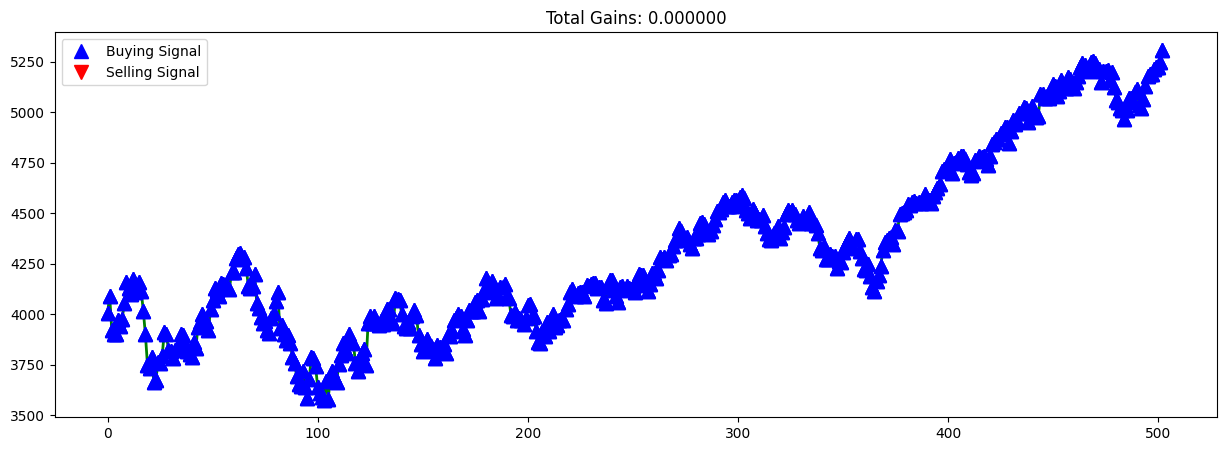

In [41]:
for t in range(l_test):
    action = eval_agent.act(state)
    next_state = getState(test_data, t + 1, window_size + 1)
    reward = 0
    
    if action == 1:
        eval_agent.inventory.append(test_data[t])
        states_buy_test.append(t)
        print("Buy: ", formatPrice(test_data[t]))
    elif action == 2 and len(eval_agent.inventory) > 0:
        bought_price = eval_agent.inventory.pop(0)
        reward = max(test_data[t] - bought_price, 0)
        total_profit += (test_data[t] - bought_price)
        states_sell_test.append(t)
        print("Sell: ", formatPrice(test_data[t]))
        print("Profit: " + formatPrice(test_data[t] - bought_price))
    
    done = True if t == l_test - 1 else False
    state = next_state
    
    if done:
        print("------------------------------------------")
        print("Total Profit: " + formatPrice(total_profit))
        print("------------------------------------------")
        
plot_behavior(test_data,states_buy_test, states_sell_test, total_profit)